Importing the required Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from google.colab import files
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats

Uploading files from the local files to google colab using colab functions

In [ ]:
files.upload()

Reading the Datasets

In [ ]:
train = pd.read_csv('train.csv')
numbers = train.shape[0]
test = pd.read_csv('test.csv')
Id = test['Id']

Probability plot of logarithmic of SalePrice 

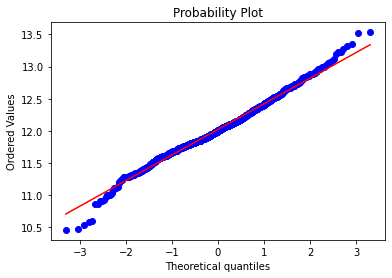

In [ ]:
stats.probplot(np.log(train['SalePrice']),plot=plt)
plt.show()

Distribution plot of logarithmic of SalePrice

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


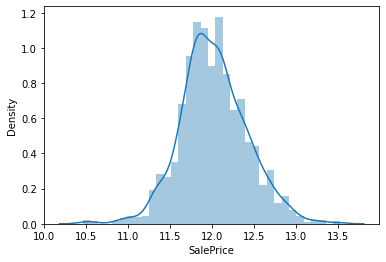

In [ ]:
sns.distplot(np.log(train['SalePrice']))

In [ ]:
np.log(train['SalePrice']).skew()

0.12133506220520406

Combining both train and test datasets for effective preprocessing

In [ ]:
total = pd.concat((train,test)).reset_index(drop=True)

In [ ]:
total.shape

(2919, 81)

In [ ]:
total.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


Columns with Nan entries in Descending order

In [ ]:
total.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
Foundation          0
Id                  0
Length: 81, dtype: int64

Dropping columns with high Nan entries 

In [ ]:
total.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','YrSold','MoSold','LotFrontage'],1,inplace=True)

In [ ]:
#plt.scatter(train['LotFrontage'],train['SalePrice'])

In [ ]:
#total["LotFrontage"] = total.groupby("Neighborhood")["LotFrontage"].transform(
    #lambda x: x.fillna(x.median()))

Plot between Ground Living Area and Sale Price

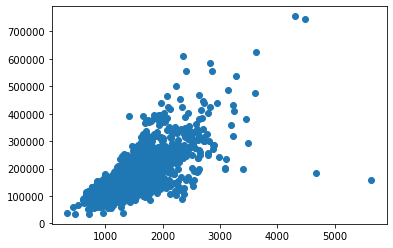

In [ ]:
plt.scatter(total['GrLivArea'],total['SalePrice'])

In [ ]:
total.drop('Utilities',1,inplace=True)

Filling columns with low number of NaN entries with the respective column's mode/median depending upon the data description

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    total[col] = total[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    total[col] = total[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    total[col] = total[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    total[col] =total[col].fillna('None')

total["MasVnrType"] = total["MasVnrType"].fillna("None")

total["MasVnrArea"] = total["MasVnrArea"].fillna(0)

total['Electrical'] = total['Electrical'].fillna(total['Electrical'].mode()[0])

total['MSZoning'] = total['MSZoning'].fillna(total['MSZoning'].mode()[0])

total['Functional'] = total['Functional'].fillna(total['Functional'].mode()[0])

total['SaleType'] = total['SaleType'].fillna(total['SaleType'].mode()[0])

total['KitchenQual'] = total['KitchenQual'].fillna(total['KitchenQual'].mode()[0])

total['Exterior1st'] = total['Exterior1st'].fillna(total['Exterior1st'].mode()[0])

total['Exterior2nd'] = total['Exterior2nd'].fillna(total['Exterior2nd'].mode()[0])

In [ ]:
total['KitchenQual'].head()

0    Gd
1    TA
2    Gd
3    Gd
4    Gd
Name: KitchenQual, dtype: object

Box plot between Kitchen Quality and SalePrice

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


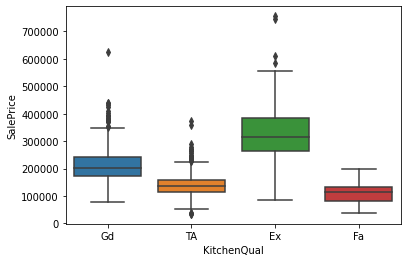

In [ ]:
sns.boxplot(total['KitchenQual'],total['SalePrice'])

One Hot Encoding of columns with object data types

In [ ]:
#train['OverallCond']=train['OverallCond'].astype(str)

total = pd.get_dummies(total)
total.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,208500.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,181500.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,223500.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,140000.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,250000.0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
total['OverallQual'].value_counts()

5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     31
2      13
1       4
Name: OverallQual, dtype: int64

Retaining the the train and test sets which are preprocessed

In [ ]:
test = total[numbers:]
final_train = total[:numbers]

In [ ]:
final_train.shape

(1460, 276)

Dropping Id in train set \\
Dropping Id and SalePrice in test set

In [ ]:
final_train.drop('Id',1,inplace=True)
test.drop(['Id','SalePrice'],1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


splitting some part of the train set for validation

In [ ]:
train,val=train_test_split(final_train,test_size=0.13,random_state=1)
x_train = train.drop('SalePrice',1)
x_val = val.drop('SalePrice',1)
y_train = train['SalePrice']
y_val = val['SalePrice']

applying logarithm to the SalePrice

In [ ]:
y_val = np.log(y_val)
y_train =np.log(y_train)

Model with GradientBoodting,XGBoosting,Kernel,lasso regressors

In [ ]:
est=[('GBR',GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt', 
                                   loss='huber')),
     ('XGBR',xgb.XGBRegressor(learning_rate=0.05, n_estimators=1000)),
     ('lgbr',lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,)),
     ('kernel',sklearn.pipeline.make_pipeline(sklearn.preprocessing.MaxAbsScaler(),
                                             KernelRidge(
                                             alpha=0.6, kernel='polynomial', degree=2))),
      ('elast',sklearn.pipeline.make_pipeline(sklearn.preprocessing.MaxAbsScaler(),
                                              sklearn.linear_model.ElasticNet(alpha=0.05, l1_ratio=0.9))),
     ('lasso',sklearn.pipeline.make_pipeline(sklearn.preprocessing.MaxAbsScaler(),sklearn.linear_model.Lasso(alpha =0.05)))]
#final_est= GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                                   #max_depth=4, max_features='sqrt',
                                   #min_samples_leaf=15, min_samples_split=10, 
                                   #loss='huber', random_state =5)

In [ ]:
#Input = [('scale',sklearn.preprocessing.MaxAbsScaler()),('model',sklearn.ensemble.VotingRegressor(est))]

Stacking Regressor model

In [ ]:
pipe_model = sklearn.ensemble.StackingRegressor(est)
pipe_model.fit(x_train,y_train)

[11:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=None,
                  estimators=[('GBR',
                               GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.05,
                                                         loss='huber',
                                                         max_depth=4,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                           

Root mean Squared Error of Train and validation sets respectively

In [ ]:
print(np.sqrt(sklearn.metrics.mean_squared_error(np.exp(y_train),np.exp(pipe_model.predict(x_train)))))
np.sqrt(sklearn.metrics.mean_squared_error(np.exp(y_val),np.exp(pipe_model.predict(x_val))))

8304.492555219997


20326.708515252594

Prediction of test set

In [ ]:
pipe_model.predict(test)

array([11.69815618, 11.97509059, 12.14730899, ..., 11.94984086,
       11.64457009, 12.30946761])

converting the predicted results to a dataframe to save it and submit

In [ ]:
sub = pd.DataFrame({'Id':Id,'SalePrice':pipe_model.predict(test)})

In [ ]:
sub.reset_index(drop=True,inplace=True)

In [ ]:
sub['SalePrice']=np.exp(sub['SalePrice'])
sub.head(15)

,Id,SalePrice
0,1461,120349.607114
1,1462,158750.741441
2,1463,188585.920518
3,1464,197310.508302
4,1465,184339.744323
5,1466,175060.727371
6,1467,179685.607240
7,1468,168443.699755
8,1469,181225.520170
9,1470,126285.976588


In [ ]:
sub.to_csv('sub21.csv',index=False)
files.download('sub21.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>